In [18]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'c46a9435-c957-4e6c-a0f4-b9a597984773'
resource_group = 'mlops'
workspace_name = 'mlopsdev'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='sampletimeseries')
dataset.to_pandas_dataframe()

,day_datetime,store,sales_quantity,week_of_year
0,2018-09-03,A,2000,36
1,2018-09-03,B,600,36
2,2018-09-04,A,2300,36
3,2018-09-04,B,550,36
4,2018-09-05,A,2100,36
5,2018-09-05,B,650,36
6,2018-09-06,A,2400,36
7,2018-09-06,B,700,36
8,2018-09-07,A,2450,36
9,2018-09-07,B,650,36


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

In [6]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [19]:
df = dataset.to_pandas_dataframe()

In [20]:
df.head(5)

,day_datetime,store,sales_quantity,week_of_year
0,2018-09-03,A,2000,36
1,2018-09-03,B,600,36
2,2018-09-04,A,2300,36
3,2018-09-04,B,550,36
4,2018-09-05,A,2100,36


In [21]:
df['date_time'] = pd.to_datetime(df.day_datetime.astype(str))

In [22]:
df['sales_quantity'] = pd.to_numeric(df['sales_quantity'], errors='coerce')

In [23]:
df = df.dropna(subset=['sales_quantity'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','sales_quantity', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [24]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (18, 7)
The time series starts from:  2018-09-03 00:00:00
The time series ends on:  2018-09-11 00:00:00


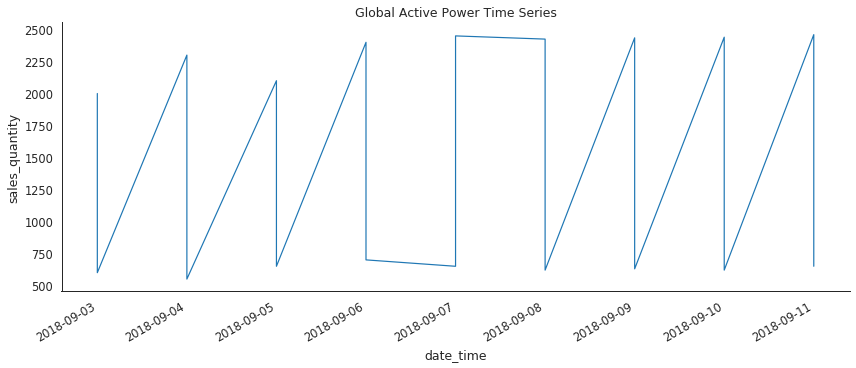

In [25]:
df1=df.loc[:,['date_time','sales_quantity']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('sales_quantity')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

In [27]:
df.head(5)

,date_time,sales_quantity,year,quarter,month,day,weekday
0,2018-09-03,2000,2018,3,9,3,1
1,2018-09-03,600,2018,3,9,3,1
2,2018-09-04,2300,2018,3,9,4,1
3,2018-09-04,550,2018,3,9,4,1
4,2018-09-05,2100,2018,3,9,5,1


In [54]:
dataset = df.sales_quantity.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [57]:
print(X_train)

[[0.7591623  0.026178   0.9162303  0.         0.8115183 ]
 [0.026178   0.9162303  0.         0.8115183  0.05235603]
 [0.9162303  0.         0.8115183  0.05235603 0.9685863 ]
 [0.         0.8115183  0.05235603 0.9685863  0.07853404]
 [0.8115183  0.05235603 0.9685863  0.07853404 0.05235603]
 [0.05235603 0.9685863  0.07853404 0.05235603 0.9947643 ]
 [0.9685863  0.07853404 0.05235603 0.9947643  0.9816754 ]
 [0.07853404 0.05235603 0.9947643  0.9816754  0.03664923]]


In [56]:
print(Y_test)

[]


In [58]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

IndexError: tuple index out of range

In [59]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (0, 1)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))